# Optimize Jupyterhub resources
In this notebook, we collect Jupyterhub usage metrics from thanos and analyze it. The end goal is to define a data driven resource allocation policy that optimizes cluster usage. Specifically, we want to suggest Request and Limit parameters such that the least amount of cluster resources (cpu and memory) are used. The resources specified using the _Request_ parameter are guaranteed to be available to the pod. The resources specified using the _Limit_ parameter are the maximum a pod can use subject to availability. The experiments in this notebook are for CPU usage as it is a priority, we can easily repeat them for memory usage.

## Contents

* Fetch metrics and plot distribution
    - Usage, limit, and request metrics
    - Distribution plots
* Recommend default profile
    - Quantiles for all the data 
* Recommend tiers using clustering
    - K-means and K computation
    - Result analysis
    - Tier Suggestion
* Percentage of resources saved   
    - Comparison of suggested configuration and current configuration

In [1]:
## Import libraries
from prometheus_api_client import PrometheusConnect
from prometheus_api_client.metric_range_df import MetricRangeDataFrame
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.matlib as npm
from sklearn.cluster import KMeans
import umap.umap_ as umap
import warnings
import hashlib

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rc("figure", figsize=(20, 10))
sns.set()

# Fetch metrics
- The data used in this analysis is from March 2021 (inception of the Thanos instance) to May 2021.

In [2]:
prom_url = (
    "https://thanos-query-frontend-opf-observatorium.apps.smaug.na.operate-first.cloud"
)
# Creating the prometheus connect object with the required parameters
# To get your token, login to moc operate first dashboard
# click on your username on top right
# copy login command and display token
pc = PrometheusConnect(
    url=prom_url,
    disable_ssl=False,
    headers={"Authorization": "bearer [token]"},
)
# Fetching a list of all metrics scraped by the Prometheus host.
all_metrics = pd.DataFrame(pc.all_metrics(), columns={"metrics"})

In [3]:
## Define function to fetch data for a start time and end time
start_time = datetime(2021, 10, 1, 12)
end_time = datetime(2021, 12, 1, 12)


def fetch_metric(metric_name, start_time, end_time):
    # Request last week's data
    metric_data = pc.get_metric_range_data(
        metric_name,  # metric name and label config
        start_time=start_time,  # datetime object for metric range start time
        end_time=end_time,  # datetime object for metric range end time
        # params = {"step":"60"},
        chunk_size=timedelta(
            days=1
        ),  # timedelta object for duration of metric data downloaded in one request
    )

    ## Make the dataframe
    metric_df = MetricRangeDataFrame(metric_data)
    metric_df.index = pd.to_datetime(metric_df.index, unit="s", utc=True)

    return metric_df


def hash_str(x):
    """
    Takes in a string and returns it's hash
    """
    hash_object = hashlib.sha224(x.encode("utf-8"))
    return hash_object.hexdigest()

In [4]:
pod_cpu_usage = fetch_metric(
    "pod:container_cpu_usage:sum{namespace='opf-jupyterhub', pod=~'jupyterhub-nb.*'}",
    start_time,
    end_time,
)
pod_cpu_usage = pod_cpu_usage[["pod", "value"]]
pod_cpu_usage["pod"] = pod_cpu_usage["pod"].apply(hash_str)
pod_cpu_usage.describe()

,pod,value
count,97715,97715
unique,41,95582
top,ac380fbbe7d9de8e998899a8fa2e4725e150fad79596ae...,0
freq,5234,281


In [5]:
pod_cpu_request = fetch_metric(
    "kube_pod_resource_request{namespace='opf-jupyterhub', resource='cpu'}",
    start_time,
    end_time,
)
pod_cpu_request = pod_cpu_request[["container", "instance", "node", "pod", "value"]]
pod_cpu_request["pod"] = pod_cpu_request["pod"].apply(hash_str)
pod_cpu_request.describe()

,container,instance,node,pod,value
count,117948,117948,117948,117948,117948
unique,1,1,14,46,6
top,kube-scheduler,128.52.62.187:10259,oct-03-19-compute,586e6a5eea66472ce929ac5c72f900a9da515eb9a70048...,0.08
freq,117948,117948,24124,5247,52029


In [6]:
pod_cpu_limit = fetch_metric(
    "kube_pod_resource_limit{namespace='opf-jupyterhub', resource='cpu'}",
    start_time,
    end_time,
)
pod_cpu_limit = pod_cpu_limit[["container", "instance", "node", "pod", "value"]]
pod_cpu_limit["pod"] = pod_cpu_limit["pod"].apply(hash_str)
pod_cpu_limit.describe()

,container,instance,node,pod,value
count,117951,117951,117951,117951,117951
unique,1,1,14,46,6
top,kube-scheduler,128.52.62.187:10259,oct-03-19-compute,ac380fbbe7d9de8e998899a8fa2e4725e150fad79596ae...,1
freq,117951,117951,24125,5248,59411


In [7]:
## Resample data to 5min interval
def sum_resample(x):
    temp = x.groupby("timestamp")["value"].sum()
    temp = temp.astype("float").resample("5min").mean().fillna(0)
    return temp


pcu_resampled = (
    pod_cpu_usage.groupby("pod")
    .apply(lambda x: x["value"].astype("float").resample("5min").mean())
    .reset_index()
)

pcl_resampled = pod_cpu_limit.groupby("pod").apply(sum_resample).reset_index()

pcr_resampled = pod_cpu_request.groupby("pod").apply(sum_resample).reset_index()

In [8]:
# Set index for merging
pcl_resampled.set_index(["pod", "timestamp"], inplace=True)
pcr_resampled.set_index(["pod", "timestamp"], inplace=True)
pcu_resampled.set_index(["pod", "timestamp"], inplace=True)

In [9]:
## Here, we are merging (inner join) usage, request, and limit time series dataframes
## These merges are lossy since life isn't perfect
## and there are missing values
## Over the long run, and a large datset
## these missing values don't affect the final output

rl = pd.merge(pcr_resampled, pcl_resampled, left_index=True, right_index=True)
rl.rename(columns={"value_x": "request", "value_y": "limit"}, inplace=True)
rlu = pd.merge(pcu_resampled, rl, left_index=True, right_index=True)
rlu.rename(columns={"value": "usage"}, inplace=True)
rlu = rlu[["usage", "request", "limit"]]
rlu.head()

usage  \
pod                                                timestamp                             
004606a440089b7b30b18d3d5798bfedc725dc4e3d72071... 2021-11-18 17:20:00+00:00  0.000029   
                                                   2021-11-18 17:25:00+00:00  0.000030   
                                                   2021-11-18 17:30:00+00:00  0.000029   
                                                   2021-11-18 17:35:00+00:00  0.000032   
                                                   2021-11-18 17:40:00+00:00  0.000030   

                                                                              request  \
pod                                                timestamp                            
004606a440089b7b30b18d3d5798bfedc725dc4e3d72071... 2021-11-18 17:20:00+00:00     0.08   
                                                   2021-11-18 17:25:00+00:00     0.08   
                                                   2021-11-18 17:30:00+00:00     0.08   
                                                   2021-11-18 17:35:00+00:00     0.08   
                                                   2021-11-18 17:40:00+00:00     0.08   

                                                                              limit  
pod                                                timestamp                         
004606a440089b7b30b18d3d5798bfedc725dc4e3d72071... 2021-11-18 17:20:00+00:00    1.0  
                                                   2021-11-18 17:25:00+00:00    1.0  
                                                   2021-11-18 17:30:00+00:00    1.0  
                                                   2021-11-18 17:35:00+00:00    1.0  
                                                   2021-11-18 17:40:00+00:00    1.0

In [10]:
rlu.describe()

,usage,request,limit
count,10053.000000,66114.000000,66114.000000
mean,0.938938,0.022675,0.457786
std,2.041157,0.077997,1.531270
min,0.000000,0.000000,0.000000
25%,0.000289,0.000000,0.000000
50%,0.002107,0.000000,0.000000
75%,0.008466,0.000000,0.000000
max,9.214830,0.500000,9.000000


In [11]:
# Remove instances of 0 request and limit values
rlu_cleaned = rlu.loc[(rlu["request"] != 0) | (rlu["limit"] != 0)]
rlu_cleaned["usage"] = rlu_cleaned["usage"].fillna(0)

# Save interim dataset to save development time
rlu_cleaned.to_pickle("../../data/interim/temp-df.pkl")
rlu_cleaned = pd.read_pickle("../../data/interim/temp-df.pkl")

In [12]:
## Create long form of the table for plotting
long_rlu_cleaned = pd.melt(
    rlu_cleaned, value_vars=["usage", "request", "limit"], ignore_index=False
)
long_rlu_cleaned = long_rlu_cleaned.reset_index().drop("pod", axis=1)

# Plot time series and distributions

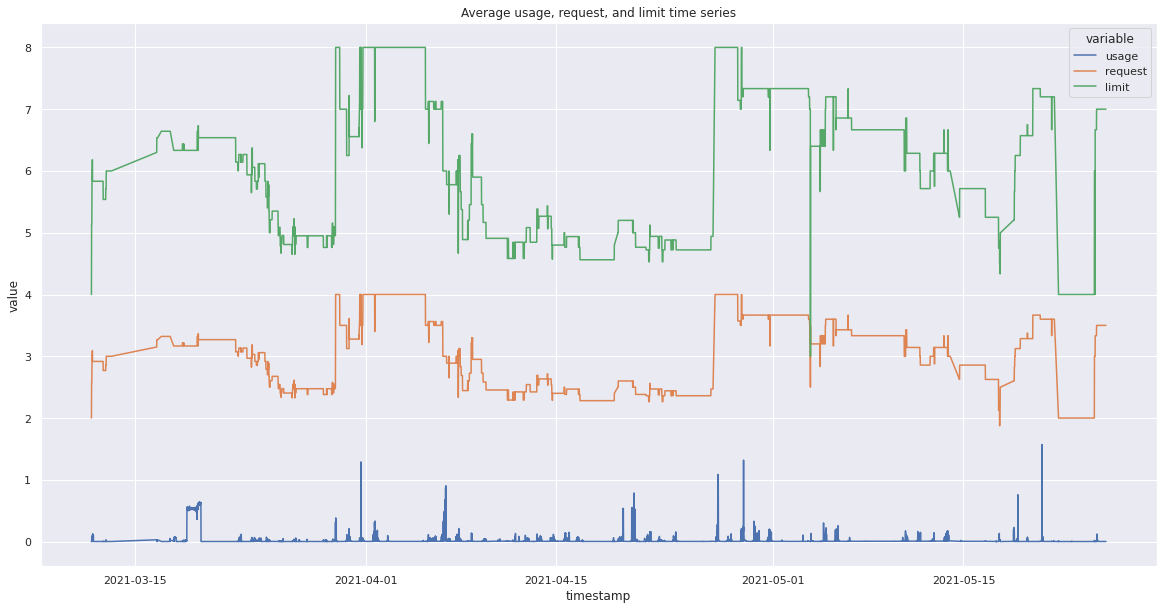

In [13]:
## Create a table for time series plot
ts_rlu = rlu_cleaned.reset_index().drop("pod", axis=1).groupby("timestamp").mean()
long_ts_rlu = pd.melt(
    ts_rlu, value_vars=["usage", "request", "limit"], ignore_index=False
).reset_index()
plt.rc("figure", figsize=(20, 10))
sns.lineplot(data=long_ts_rlu, x="timestamp", y="value", hue="variable")
plt.title("Average usage, request, and limit time series")
plt.show()

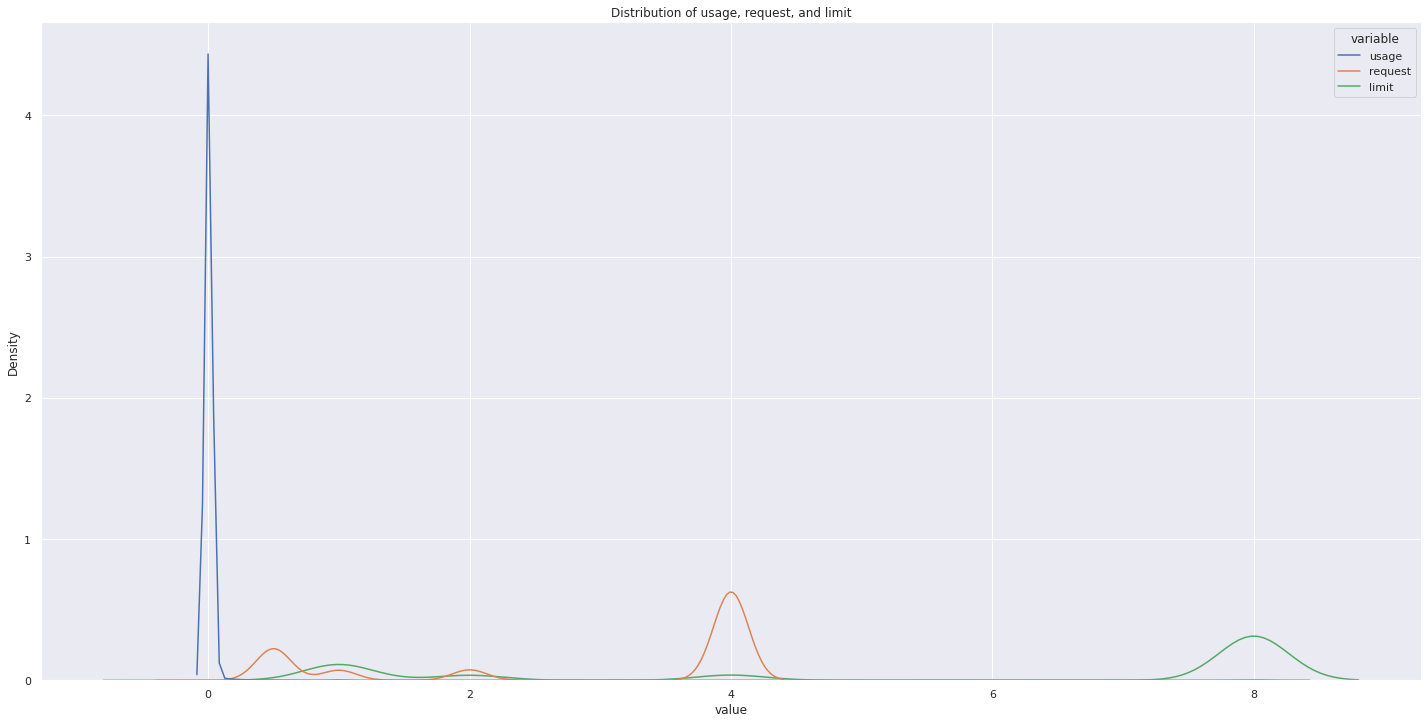

In [14]:
## Plot the overall distribution of usage
sns.displot(
    data=long_rlu_cleaned,
    x="value",
    kind="kde",
    hue="variable",
    facet_kws={"legend_out": False},
    height=10,
    aspect=2,
)
plt.title("Distribution of usage, request, and limit")
plt.show()

Let's inspect the distribution of CPU consumption of some individual users of Jupyterhub.

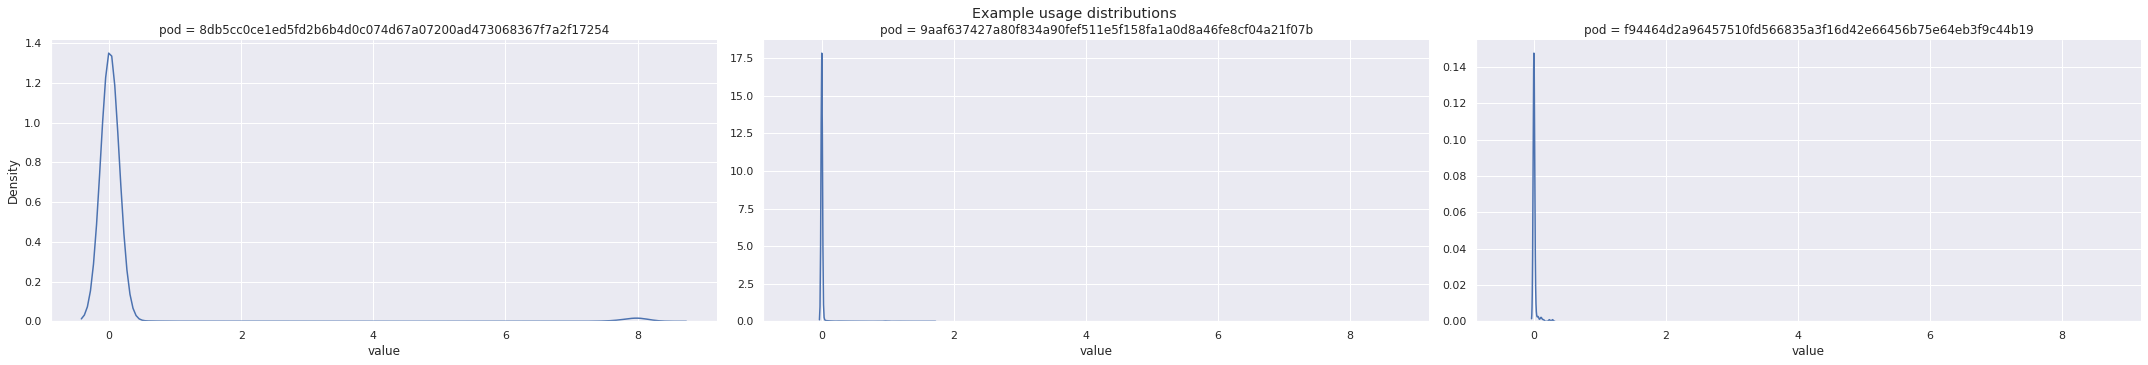

In [15]:
usage_df = rlu_cleaned["usage"].reset_index().rename(columns={"usage": "value"})
d = usage_df[
    (usage_df["pod"] == "8db5cc0ce1ed5fd2b6b4d0c074d67a07200ad473068367f7a2f17254")
    | (usage_df["pod"] == "9aaf637427a80f834a90fef511e5f158fa1a0d8a46fe8cf04a21f07b")
    | (usage_df["pod"] == "f94464d2a96457510fd566835a3f16d42e66456b75e64eb3f9c44b19")
]

rel = sns.displot(
    data=d,
    x="value",
    kind="kde",
    col="pod",
    facet_kws={"sharey": False},
    height=5,
    aspect=2,
)

rel.fig.suptitle("Example usage distributions", y=1.01)
plt.show()

From the distribution plots, we see that it is highly skewed. In most cases there is a high density around a very small CPU usage (around 0) and for some users there are instances of high usage. This suggests:
  - At any given moment, the average usage should be very less than the maximum available.
  - Occasionally, the usage goes up as users run intensive workloads.
  - Since the data is skewed, we should look at quantiles instead of mean and standard deviation.

# Recommend default profile

In [16]:
def quantiles(x):
    """Given a series of values,
    returns 50th, 75th, 90th, 99th, and 100th quantile
    """
    qu_50 = x.value.quantile(q=0.50).round(4)
    qu_75 = x.value.quantile(q=0.75).round(4)
    qu_90 = x.value.quantile(q=0.90).round(4)
    qu_99 = x.value.quantile(q=0.99).round(4)
    ## Same as max
    qu_100 = x.value.quantile(q=1).round(4)
    return (qu_50, qu_75, qu_90, qu_99, qu_100)


def req_lim(x):
    """
    Apply method for metric dataframe
    to get quantiles
    """
    x["Req_50"], x["Req_75"], x["Req_90"], x["Req_99"], x["Limit"] = quantiles(x)
    x = x[["Req_50", "Req_75", "Req_90", "Req_99", "Limit"]]
    x.drop_duplicates(inplace=True)
    return x


def print_results(results, resource, category, unit):
    print(
        f"{resource} usage for {category} user, 50% of the times, is less than: ",
        results[0],
        unit,
    )
    print(
        f"{resource} usage for {category} user, 75% of the times, is less than: ",
        results[1],
        unit,
    )
    print(
        f"{resource} usage for {category} user, 90% of the times, is less than: ",
        results[2],
        unit,
    )
    print(
        f"{resource} usage for {category} user, 99% of the times, is less than: ",
        results[3],
        unit,
    )
    print(
        f"{resource} usage for {category} user, 100% of the times, is less than: ",
        results[4],
        unit,
    )

In [17]:
cpu_limits = usage_df.groupby("pod").apply(req_lim)
cpu_limits.reset_index(drop=True, level=1, inplace=True)
cpu_limits

,Req_50,Req_75,Req_90,Req_99,Limit
pod,,,,,
042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae9166b86bbef7,0.0019,0.0021,0.0023,0.0032,0.0618
0b11e9b95a1e983c1eb1ddb77ad0edda6b6531af1129bce267cc4236,0.0014,0.0017,0.0037,0.0105,1.8647
0d74a87b981dc2215696d2604b671d475e309ee2809e7798ba87a253,0.0001,0.0002,0.0003,0.0003,0.0425
1543488c4500b993b03c6c8e4af5123d784f4330672a031daad6f708,0.0002,0.0032,0.0398,0.0590,0.2092
1f80e502045b3736f48670e320983b9dcf451e5d04505215dcfbabe0,0.0574,0.0574,0.0574,0.0574,0.0574
2243bd2d4de82dae19c84827cba10f0cde04cfcae2263100a769206d,0.0015,0.0015,0.0016,0.0044,0.0397
226644037ee9825c32a66300b7cbb92cabe17fe78278cc921efef114,0.0017,0.0041,0.0114,0.0120,0.3308
23fcc8791bd449c16fa9e34447f6e9243cb66722748feb8efe071a5d,0.0012,0.0013,0.0013,0.0382,0.0463
240f30ce54d17103d911eb2436d6a625a8e65a1568053d41bf7408be,0.0000,0.0000,0.0000,0.0000,0.0111


This table shows quantile CPU usage of all the Jupyterhub users. We could potentially use this pattern to define custom resources for each user. But at the moment, we should focus on the default profile and resource tiers.

In [18]:
print_results(quantiles(usage_df), "CPU", "default", "cores")

CPU usage for default user, 50% of the times, is less than:  0.0016 cores
CPU usage for default user, 75% of the times, is less than:  0.0032 cores
CPU usage for default user, 90% of the times, is less than:  0.0094 cores
CPU usage for default user, 99% of the times, is less than:  0.1105 cores
CPU usage for default user, 100% of the times, is less than:  8.3431 cores


Here we see CPU quantiles for all the users at different levels. We can use them to configure the default profile for Jupyterhub. For example, the 99% quantile (~ 0.12) for CPU can be used as a request and 100% quantile (~ 8.5) can be used as a limit. However, we should take into account that when we see the limit touched that means the workload is designed to use as many resources as available. And so, we can increase the limit for better performance. If the resources are under pressure, we can choose a more conservative default. Next, we are going to look at how we can find different t-shirt sizes for the resource usage profiles.

## Recommend tiers using clustering
- The idea here is to group users together based on their usage. Then, we analyze the usage of each group and define the best profile for that group. This serves as a recommendation of the resource profile tier or the t-shirt size. 
- For features, we use quantiles of the resource usage time series. In next versions, we can evaluate more descriptive features of the time series.

In [19]:
def quantile_features(x):
    """
    Apply method for metric dataframe
    to get quantile features for resource
    consumption
    """
    for q in np.arange(0, 1.1, 0.1):
        x[f"qt_{int(q*100)}"] = x.value.quantile(q=q).round(4)
    x.drop(["timestamp", "value", "pod"], axis=1, inplace=True)
    x.drop_duplicates(inplace=True)
    return x

In [20]:
def best_k(curve):
    """
    Function that finds the elbow/knee of a curve.
    credits: https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    """
    npoints = len(curve)
    allcoord = np.vstack((range(npoints), curve)).T
    np.array([range(npoints), curve])
    firstpoint = allcoord[0]
    linevec = allcoord[-1] - allcoord[0]
    linevecnorm = linevec / np.sqrt(np.sum(linevec ** 2))
    vecfromfirst = allcoord - firstpoint
    scalarproduct = np.sum(vecfromfirst * npm.repmat(linevecnorm, npoints, 1), axis=1)
    vecfromfirstparallel = np.outer(scalarproduct, linevecnorm)
    vectoline = vecfromfirst - vecfromfirstparallel
    disttoline = np.sqrt(np.sum(vectoline ** 2, axis=1))
    idxofbestpoint = np.argmax(disttoline)
    return idxofbestpoint + 1

In [21]:
## Find quantile features
cpu_features = usage_df.groupby("pod").apply(quantile_features)
cpu_features.reset_index(drop=True, level=1, inplace=True)
cpu_features.head()

,qt_0,qt_10,qt_20,qt_30,qt_40,qt_50,qt_60,qt_70,qt_80,qt_90,qt_100
pod,,,,,,,,,,,
042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae9166b86bbef7,0.0000,0.0011,0.0017,0.0018,0.0019,0.0019,0.0020,0.0021,0.0022,0.0023,0.0618
0b11e9b95a1e983c1eb1ddb77ad0edda6b6531af1129bce267cc4236,0.0000,0.0002,0.0012,0.0013,0.0014,0.0014,0.0016,0.0016,0.0025,0.0037,1.8647
0d74a87b981dc2215696d2604b671d475e309ee2809e7798ba87a253,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0002,0.0002,0.0003,0.0425
1543488c4500b993b03c6c8e4af5123d784f4330672a031daad6f708,0.0000,0.0000,0.0000,0.0002,0.0002,0.0002,0.0002,0.0030,0.0044,0.0398,0.2092
1f80e502045b3736f48670e320983b9dcf451e5d04505215dcfbabe0,0.0574,0.0574,0.0574,0.0574,0.0574,0.0574,0.0574,0.0574,0.0574,0.0574,0.0574


Best k:  3


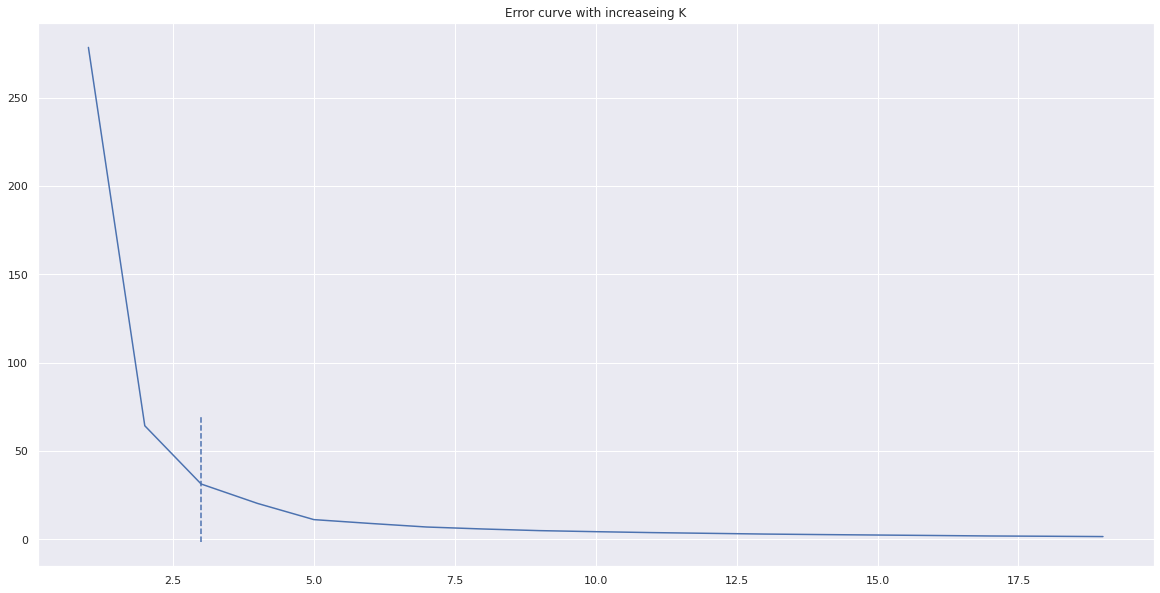

In [22]:
## Reduce dimensions for plotting
plot_components = 2
mapper = umap.UMAP(n_components=plot_components, random_state=1)
twod_embeddings = mapper.fit_transform(cpu_features)

## Find best k or number of groups
kmeans_scores = [
    KMeans(init="k-means++", n_clusters=i, n_init=100, n_jobs=-1)
    .fit(twod_embeddings)
    .inertia_
    for i in range(1, 20)
]

k = best_k(kmeans_scores)
print("Best k: ", k)
sns.lineplot(range(1, 20), kmeans_scores)
plt.vlines(
    x=k,
    ymin=-min(kmeans_scores),
    ymax=max(kmeans_scores) / 4,
    linestyles="dashed",
    label="knee",
)

plt.title("Error curve with increaseing K")
plt.show()

From this analysis, we see that the curve hits the elbow at k=3. But, the error seems most stable after k=5. For a thorough analysis, let's start with 5 types of groups or users in the dataset. We can go ahead and analyze these groups and see if we can configure _request_ and _limit_ for them.

In [23]:
## Train a Kmeans model
kmeans = KMeans(init="k-means++", n_clusters=5, n_init=1000, n_jobs=-1, random_state=0)
kmeans.fit(twod_embeddings)
cpu_features["class"] = kmeans.predict(twod_embeddings)

In [24]:
cpu_features["class"].head()

pod
042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae9166b86bbef7    3
0b11e9b95a1e983c1eb1ddb77ad0edda6b6531af1129bce267cc4236    4
0d74a87b981dc2215696d2604b671d475e309ee2809e7798ba87a253    3
1543488c4500b993b03c6c8e4af5123d784f4330672a031daad6f708    2
1f80e502045b3736f48670e320983b9dcf451e5d04505215dcfbabe0    0
Name: class, dtype: int32

Great, we see classes added to the pod users. Let's plot the clusters.

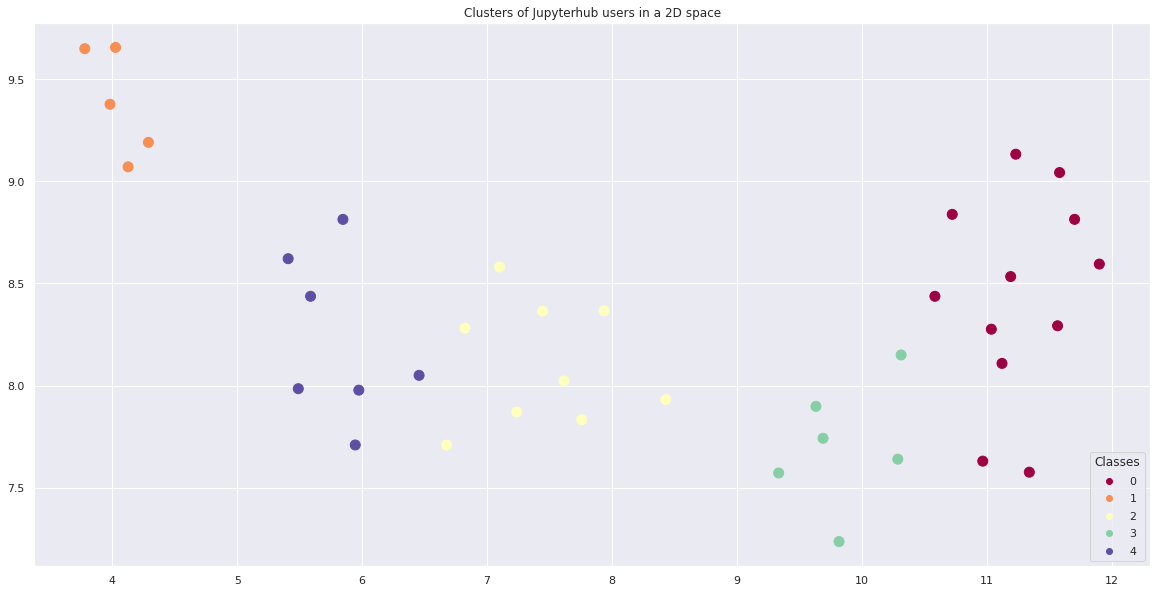

In [25]:
sns.set(style="darkgrid", rc={"figure.figsize": (20, 10)})
scatter = plt.scatter(
    twod_embeddings[:, 0],
    twod_embeddings[:, 1],
    c=cpu_features["class"],
    label=list(cpu_features["class"]),
    s=100,
    cmap="Spectral",
)
legend1 = plt.legend(*scatter.legend_elements(), loc="lower right", title="Classes")

plt.title("Clusters of Jupyterhub users in a 2D space")
plt.show()

We see 5 distinct clusters which means the clustering process was successful. Next we will look at them in detail.

In [26]:
## Check class distribution
cpu_features["class"].value_counts()

0    12
2     9
4     7
3     6
1     5
Name: class, dtype: int64

We can inspect the distribution of quantile features based on the class assigned to different users. Distribution of the 100% quantile feature is most interesting as there seems to be a clear distinction.

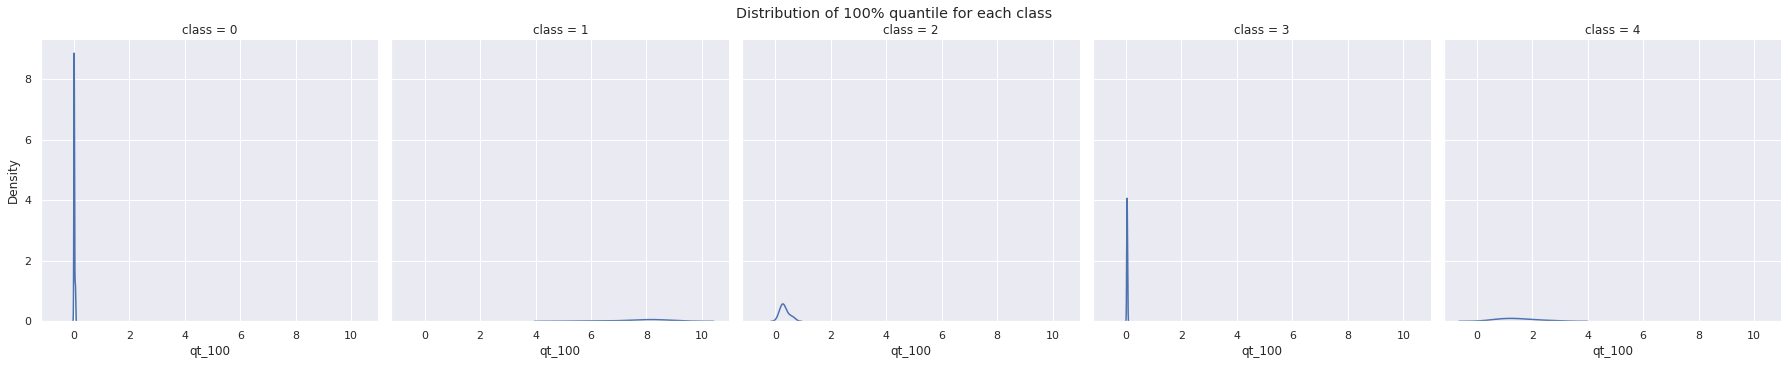

In [27]:
rel = sns.displot(data=cpu_features, x="qt_100", col="class", kind="kde")
rel.fig.suptitle("Distribution of 100% quantile for each class", y=1.01)
plt.show()

In [28]:
## Get classes in the original dataframe
usage_df["class"] = usage_df["pod"].apply(lambda x: cpu_features.loc[x]["class"])
usage_df.head()

,pod,timestamp,value,class
0,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:00:00+00:00,0.026939,3.0
1,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:05:00+00:00,0.016756,3.0
2,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:10:00+00:00,0.003217,3.0
3,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:15:00+00:00,0.003018,3.0
4,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:20:00+00:00,0.004196,3.0


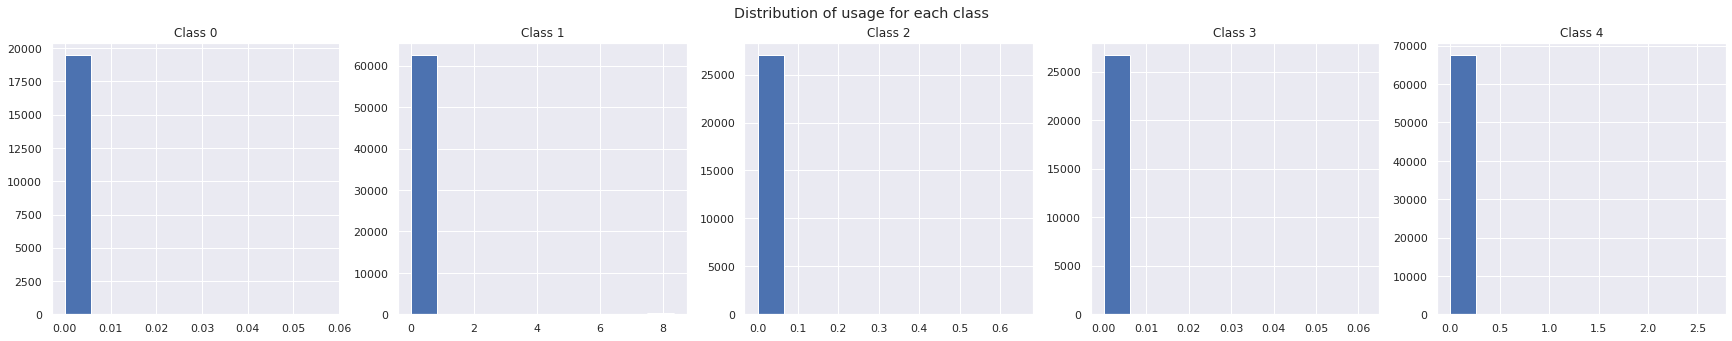

In [29]:
plt.rc("figure", figsize=(30, 5))
fig, axes = plt.subplots(1, 5)
for c in range(5):
    axes[c].hist(usage_df[usage_df["class"] == c].value)
    axes[c].title.set_text(f"Class {c}")
fig.suptitle("Distribution of usage for each class")
plt.show()

From the above graphs, we can to some extent see the usage order for classes 0<3<2<4<1. We can furthur examine this in more details, let's go and find quantiles for these classes.

In [30]:
usage_df.groupby("class").apply(req_lim)

,,Req_50,Req_75,Req_90,Req_99,Limit
class,,,,,,
0.0,20571,0.0000,0.0000,0.0000,0.0016,0.0574
1.0,47864,0.0031,0.0074,0.0171,0.4911,8.3431
2.0,17297,0.0015,0.0019,0.0036,0.0481,0.6493
3.0,0,0.0003,0.0013,0.0020,0.0025,0.0618
4.0,5204,0.0016,0.0034,0.0086,0.1482,2.6538


With a lenient resource allocation policy, we see the above table and use 99% quartile for request and 100% quantile for limit. We can also club some classes together looking at the usage and K-means scatter plot. 

* Small tier: club classes 0 and 3 users together with request = 0.003 and limit = 0.07
* Medium tier: club classes 2 and 4 users together with request = 0.12 and limit = 3
* Large tier: class 1 users with request = 0.5 and limit = 9

We can see them clearly in the following plots.

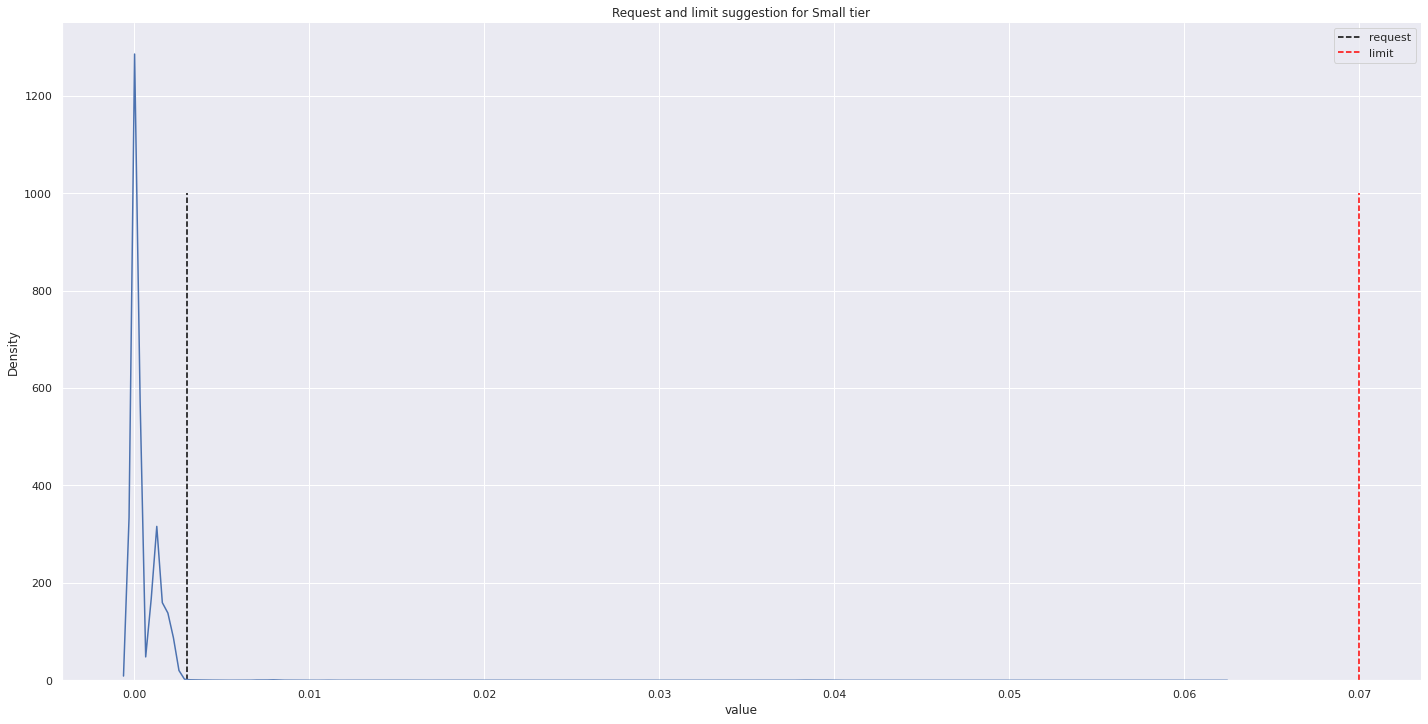

In [31]:
sns.displot(
    usage_df[(usage_df["class"] == 0) | (usage_df["class"] == 3)].value,
    kind="kde",
    height=10,
    aspect=2,
)

plt.vlines(
    x=0.003,
    ymin=0,
    ymax=1000,
    linestyles="dashed",
    label="request",
    color="black",
)

plt.vlines(x=0.07, ymin=0, ymax=1000, linestyles="dashed", label="limit", color="red")
plt.title("Request and limit suggestion for Small tier")
plt.legend()
plt.show()

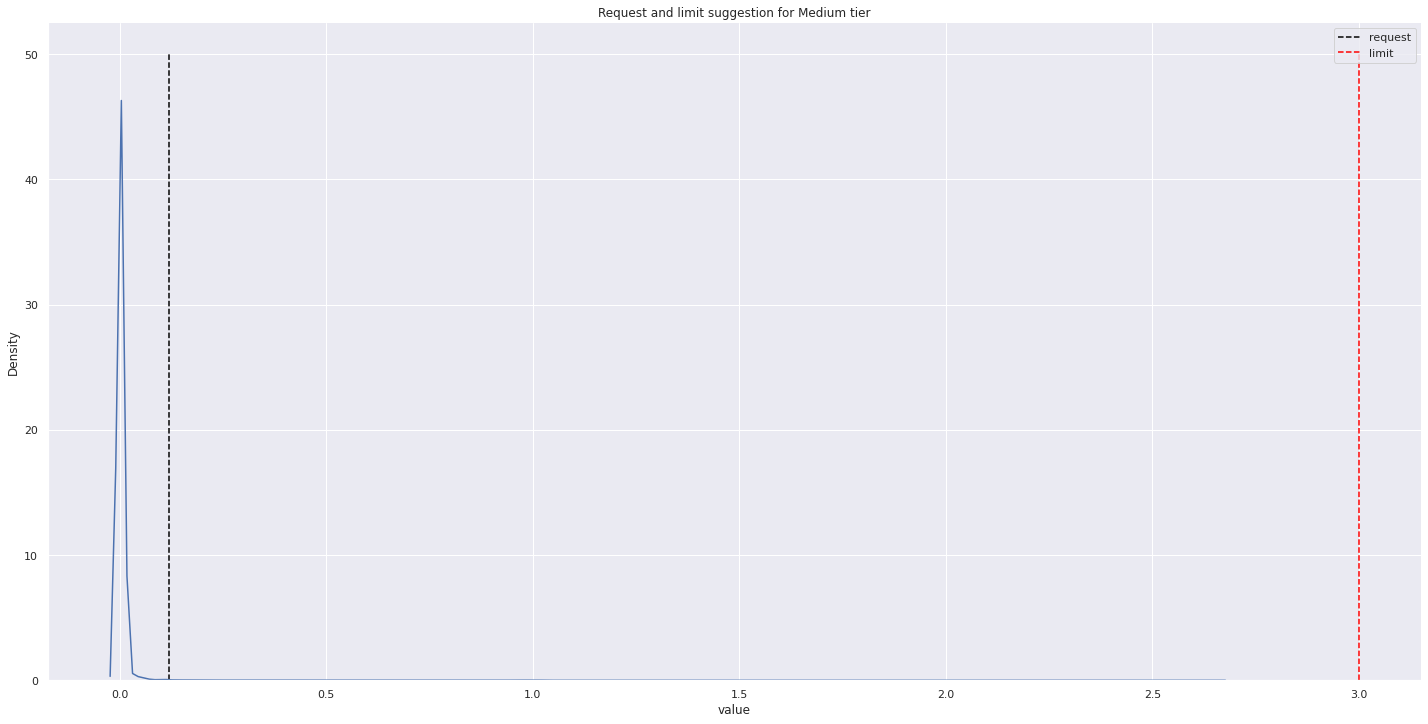

In [32]:
sns.displot(
    usage_df[(usage_df["class"] == 2) | (usage_df["class"] == 4)].value,
    kind="kde",
    height=10,
    aspect=2,
)

plt.vlines(
    x=0.12,
    ymin=0,
    ymax=50,
    linestyles="dashed",
    label="request",
    color="black",
)

plt.vlines(x=3, ymin=0, ymax=50, linestyles="dashed", label="limit", color="red")

plt.title("Request and limit suggestion for Medium tier")
plt.legend()
plt.show()

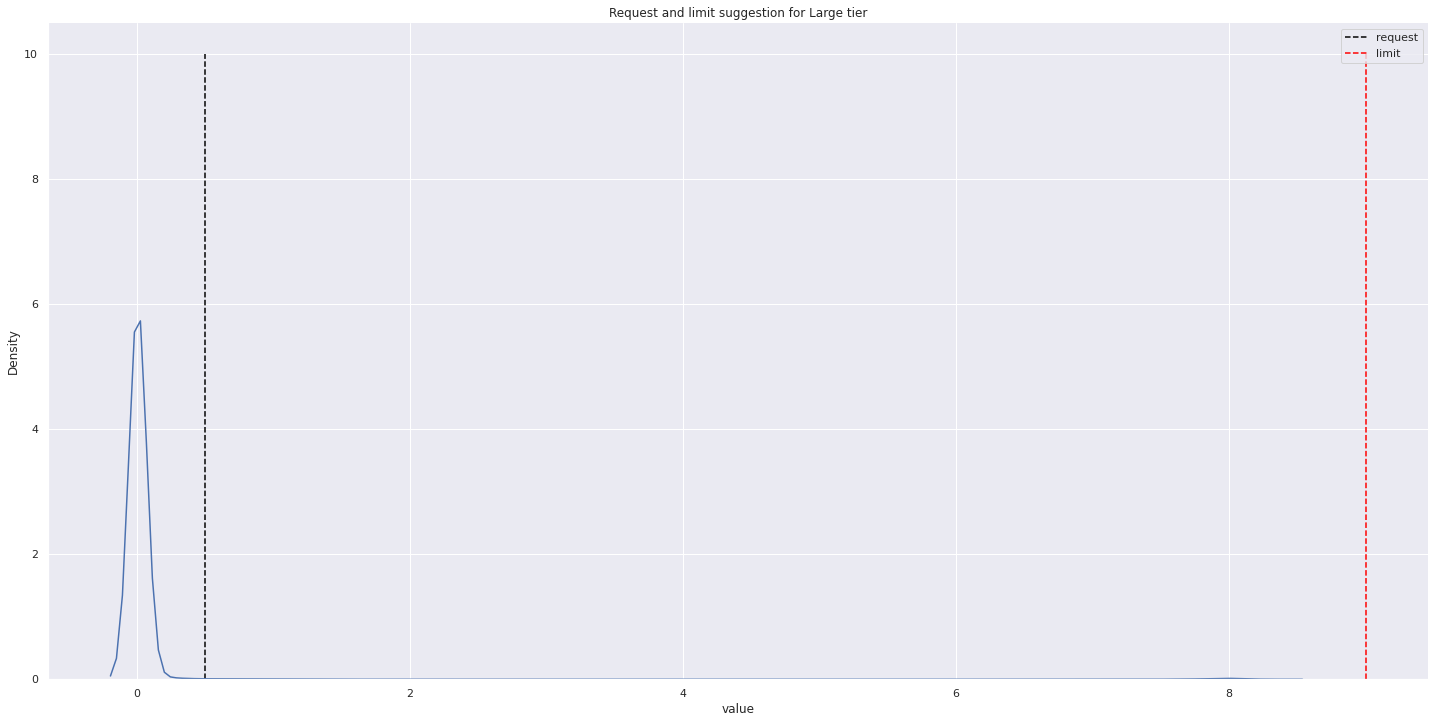

In [33]:
sns.displot(usage_df[(usage_df["class"] == 1)].value, kind="kde", height=10, aspect=2)

plt.vlines(x=0.5, ymin=0, ymax=10, linestyles="dashed", label="request", color="black")

plt.vlines(x=9, ymin=0, ymax=10, linestyles="dashed", label="limit", color="red")

plt.title("Request and limit suggestion for Large tier")
plt.legend()
plt.show()

## Percentage of resources saved
Comparison of suggested configuration and current configuration


In [34]:
rlu_cleaned.reset_index(inplace=True)
rlu_cleaned["class"] = rlu_cleaned["pod"].apply(lambda x: cpu_features.loc[x]["class"])

In [35]:
def rec_req_lim(user_class):
    rec_request, rec_limit = 0, 0
    if user_class == 0 or user_class == 3:
        rec_request, rec_limit = 0.003, 0.07
    elif user_class == 2 or user_class == 4:
        rec_request, rec_limit = 0.12, 3
    elif user_class == 1:
        rec_request, rec_limit = 0.5, 9
    return (rec_request, rec_limit)

In [36]:
rlu_cleaned["rec_request"], rlu_cleaned["rec_limit"] = zip(
    *rlu_cleaned["class"].apply(rec_req_lim)
)

### Resources saved
* In the next cell, we calculate the relative percentage of resources that will be saved if the suggested _request_ parameter is used. 
* We look at all the users and find average percentage of (current request - recommended request) / current request

In [37]:
rlu_cleaned["resource_saved"] = 100 * (
    1 - (rlu_cleaned["rec_request"] / rlu_cleaned["request"])
)
rlu_cleaned["resource_saved"] = rlu_cleaned["resource_saved"].replace(
    [np.inf, -np.inf, np.nan], 0
)

In [38]:
rlu_cleaned["resource_saved"].mean().round()

91.0

#### The results suggest a 91% request reduction.

Next, let's look at the change in resource utilization if we switch to the suggested request parameter.

In [39]:
# We see 0 values for requests and limits sometimes
# That's probably because of a cluster restart
# We fill inf and Nan with 0
rlu_cleaned["ur_cent"] = 100 * rlu_cleaned["usage"] / rlu_cleaned["request"]
rlu_cleaned["ur_cent"] = rlu_cleaned["ur_cent"].replace([np.inf, -np.inf, np.nan], 0)
rlu_cleaned["ur_cent"].mean().round(1)

0.7

Here we see that on an average, ~0.7% CPU is utilized.

In [40]:
rlu_cleaned["rec_ur_cent"] = 100 * rlu_cleaned["usage"] / rlu_cleaned["rec_request"]
rlu_cleaned["rec_ur_cent"] = rlu_cleaned["rec_ur_cent"].replace(
    [np.inf, -np.inf, np.nan], 0
)
rlu_cleaned["rec_ur_cent"].mean().round(1)

10.9

Here we see that if we use the recommended request parameter, the utilization jumps to ~11% on average.

In [41]:
rlu_cleaned.head()

,pod,timestamp,usage,request,limit,class,rec_request,rec_limit,resource_saved,ur_cent,rec_ur_cent
0,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:00:00+00:00,0.026939,0.5,1.0,3.0,0.003,0.07,99.4,5.387755,897.959144
1,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:05:00+00:00,0.016756,0.5,1.0,3.0,0.003,0.07,99.4,3.351207,558.534561
2,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:10:00+00:00,0.003217,0.5,1.0,3.0,0.003,0.07,99.4,0.643460,107.243286
3,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:15:00+00:00,0.003018,0.5,1.0,3.0,0.003,0.07,99.4,0.603584,100.597325
4,042b1a4a2eb31b71f766fab1ee96b951f6e601ed1cae91...,2021-04-05 09:20:00+00:00,0.004196,0.5,1.0,3.0,0.003,0.07,99.4,0.839124,139.853935


This is the final data frame that has all the necessary components for any further analysis with cpu usage. More hypothesis and metrics can derived from this.

## Conclusion

In this notebook, we saw how we can analyze the cpu consumption of Jupyterhub users to define resource tiers or default profiles. These resource tiers should be presented as selectable options on the spawn page accessible to the users of the Jupyterhub application. For the current situation, we found the following tier recommendation:

* **Small tier**:  _request_ = 0.003 and _limit_ = 0.07
* **Medium tier**: _request_ = 0.12 and _limit_ = 3
* **Large tier**:  _request_ = 0.5 and _limit_ = 9

If used, we see 91% reduction in CPU request and an increase from 0.7% to 10.9% overall utilization. 

Under the hood, these options are used to configure Openshift pods which makes this analysis extendable to other applications running on Openshift. In future, we can make these changes dynamic by updating user pod configuration on every cluster update looking at their recent history.